In [1]:
# essential packages

import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import io
%matplotlib inline
print("finished")

finished


In [2]:
from google.colab import drive # access the google drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [3]:
# Setting up the path to the data
path_var = '/content/drive/MyDrive/Colab Notebooks/Data/'
#count the total number of images
path, dirs, files = next(os.walk(path_var))
number_images = len(files)
print(number_images)

597


In [5]:
path_var_new = '/content/drive/MyDrive/Colab Notebooks/'
# Load the labels array
labels = np.load(path_var_new + 'labels.npy')

# Count the occurrences of each label
unique_labels, label_counts = np.unique(labels, return_counts=True)

# Print the counts
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} images")

Label 0.0: 83 images
Label 1.0: 294 images
Label 2.0: 71 images
Label 3.0: 149 images


In [ ]:
import os
import numpy as np
import math
from keras.preprocessing.image import ImageDataGenerator



# Define the augmentation parameters
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

# Indices of images for labels 0.0, 2.0, and 3.0
indices_to_augment = np.where(labels != 1.0)[0]

# Calculate the maximum count among all labels (excluding Depuy)
max_count = max([count for label, count in zip(np.unique(labels), np.bincount(labels.astype(int))) if label != 1.0])

# Calculate the augmentation factor for each label
augmentation_factors = {}
for label, count in zip(np.unique(labels), np.bincount(labels.astype(int))):
    if label != 1.0:
        augmentation_factor = math.ceil(max_count / count)
        augmentation_factors[label] = augmentation_factor

# Augment images
for index in indices_to_augment:
    img = images[index]
    img = img.reshape((1,) + img.shape)  # Reshape to (1, height, width, channels) for flow method
    label = labels[index]
    manufacturer = name_map[label]
    # Create a directory for augmented images if it doesn't exist
    save_path = os.path.join(path_var, 'augmented_images', manufacturer)
    os.makedirs(save_path, exist_ok=True)
    # Generate augmented images and save them
    i = 0
    for batch in datagen.flow(img, batch_size=1, save_to_dir=save_path, save_prefix='aug', save_format='jpg'):
        i += 1
        if i >= augmentation_factors[label]:  # Use augmentation factor for the current label
            break

# Recheck the counts after augmentation
augmented_counts = {}
augmented_images_dir = os.path.join(path_var, 'augmented_images')
for manufacturer in os.listdir(augmented_images_dir):
    manufacturer_path = os.path.join(augmented_images_dir, manufacturer)
    if os.path.isdir(manufacturer_path):
        # Count the number of files in the directory
        num_images = len(os.listdir(manufacturer_path))
        # Store the count in the dictionary
        augmented_counts[manufacturer] = num_images

# Print the counts after augmentation
for manufacturer, count in augmented_counts.items():
    print(f"{manufacturer}: {count} images")


Tornier: 420 images
Cofield: 328 images
Zimmer: 294 images


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split

# Define the path to your data
path_var_new = '/content/drive/MyDrive/Colab Notebooks/'


# Load the augmented images and labels
augmented_images = []
augmented_labels = []
augmented_images_dir = os.path.join(path_var, 'augmented_images')
for manufacturer in os.listdir(augmented_images_dir):
    manufacturer_path = os.path.join(augmented_images_dir, manufacturer)
    if os.path.isdir(manufacturer_path):
        for image_file in os.listdir(manufacturer_path):
            img = plt.imread(os.path.join(manufacturer_path, image_file), format='jpg')
            augmented_images.append(img)
            if manufacturer == 'Cofield':
                augmented_labels.append(0)
            elif manufacturer == 'Depuy':
                augmented_labels.append(1)
            elif manufacturer == 'Tornier':
                augmented_labels.append(2)
            elif manufacturer == 'Zimmer':
                augmented_labels.append(3)

# Convert lists to numpy arrays
augmented_images = np.array(augmented_images)
augmented_labels = np.array(augmented_labels)

# Combine original and augmented images
combined_images = np.concatenate((images_origin, augmented_images))

# Combine original and augmented labels
combined_labels = np.concatenate((labels, augmented_labels))

# Save the combined data and labels
np.save(os.path.join(path_var_new, 'combined_images.npy'), combined_images)
np.save(os.path.join(path_var_new, 'combined_labels.npy'), combined_labels)

# Check the shape of the saved arrays
print("Combined images shape:", combined_images.shape)
print("Combined labels shape:", combined_labels.shape)

Combined images shape: (1639, 256, 256, 3)
Combined labels shape: (1639,)


In [6]:
# Load the combined labels
combined_labels = np.load(os.path.join(path_var_new, 'combined_labels.npy'))

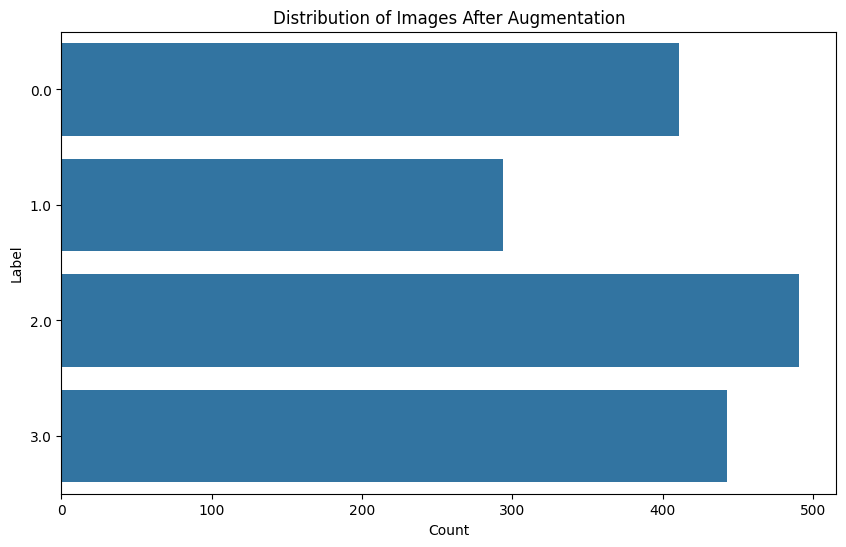

In [7]:
# Plot histogram
plt.figure(figsize=(10, 6))
sns.countplot(y=combined_labels)
plt.xlabel('Count')
plt.ylabel('Label')
plt.title('Distribution of Images After Augmentation')
plt.show()

In [ ]:
# Define the path to your data

# Load the combined images
combined_images = np.load(os.path.join(path_var_new, 'combined_images.npy'))

# Normalize the images
normalized_images = combined_images.astype('float32') / 255.0

# Save the normalized images
np.save(os.path.join(path_var_new, 'normalized_images.npy'), normalized_images)

# Check the shape of the saved array
print("Normalized images shape:", normalized_images.shape)


Normalized images shape: (1639, 256, 256, 3)


In [ ]:
import os
import numpy as np
from sklearn.model_selection import train_test_split


# Load the normalized images and labels
normalized_images = np.load(os.path.join(path_var_new, 'normalized_images.npy'))
combined_labels = np.load(os.path.join(path_var_new, 'combined_labels.npy'))

# Split the data into training and testing sets
train_images, test_images, train_labels, test_labels = train_test_split(normalized_images, combined_labels, test_size=0.2, random_state=42)

#testing path
path_test = '/content/drive/MyDrive/Colab Notebooks/Test/'

# Save the split images and labels
np.save(os.path.join(path_test, 'train_images.npy'), train_images)
np.save(os.path.join(path_test, 'train_labels.npy'), train_labels)
np.save(os.path.join(path_test, 'test_images.npy'), test_images)
np.save(os.path.join(path_test, 'test_labels.npy'), test_labels)

# Check the shapes of the saved arrays
print("Train images shape:", train_images.shape)
print("Train labels shape:", train_labels.shape)
print("Test images shape:", test_images.shape)
print("Test labels shape:", test_labels.shape)

Train images shape: (1311, 256, 256, 3)
Train labels shape: (1311,)
Test images shape: (328, 256, 256, 3)
Test labels shape: (328,)
